# LINK TO GITHUB: [Ran+Shany Repo](https://github.com/RyanWri/Afeka_DL_course_labs/tree/main/src/task_2)

**All our code is organized, you can find task2 in src/task_2 directory**

In [12]:
import os
import sys
import asyncio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nest_asyncio
import json
from statsmodels.tsa.seasonal import seasonal_decompose

# Allow nested use of asyncio.run()
nest_asyncio.apply()

**Next Cell is for Import readibility**

In [14]:
# Prepend the src directory to the PYTHONPATH
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

# Verify that the path has been added
print(sys.path[0])

c:\Afeka\Afeka_DL_course_labs


# 1 Use the dataset from UCI Machine Learning Repository
**We read the data and split it into 10 different chunks for faster reading, data files located in src/task_2/data directory**
<br>*Asyncio is an asynchornous library for fast processing time*

# 2. Perform Exploratory Data Analysis (EDA) of the dataset

In [15]:
from src.task_2.eda.eda import load_and_process_chunk

In [16]:
async def process_data_parallel():
    rootdir = os.path.join(os.getcwd(), "data")

    # Traverse Data Directory and get paths to all chunk files
    file_names = []
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            file_names.append(os.path.join(subdir, file))
            df = pd.read_csv(os.path.join(subdir, file), low_memory=False)
    
    # Load and process each chunk
    tasks = [load_and_process_chunk(file) for file in file_names]
    results = await asyncio.gather(*tasks)

    # Concatenate all chunks into a single DataFrame
    full_df = pd.concat(results)
    return full_df

# Run the asynchronous processing
full_df = asyncio.run(process_data_parallel())

**Plot basic stats on data**

In [17]:
def plot_dataframe_stats(df: pd.DataFrame):
    # Display basic info about the DataFrame
    print(df.info())
    print(df.head())

plot_dataframe_stats(full_df)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2008-12-06 07:12:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB
None
                     Global_active_power  Global_reactive_power  Voltage  \
dt                                                                         
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00         

## 2.1 Visualize Time Series Trends

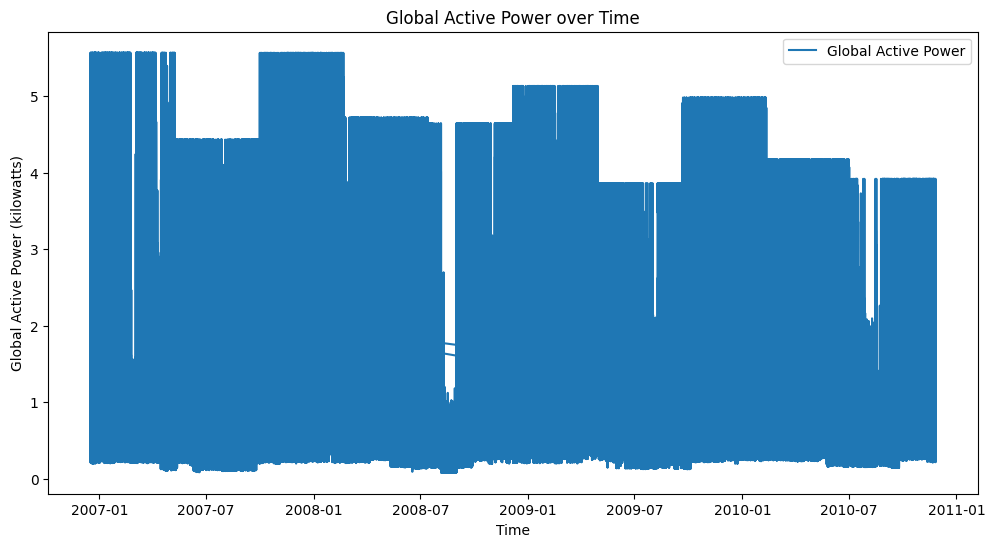

In [18]:
def visualize_time_series_trends(df: pd.DataFrame):
    # Plot Global_active_power over time
    plt.figure(figsize=(12, 6))
    plt.plot(df["Global_active_power"], label="Global Active Power")
    plt.xlabel("Time")
    plt.ylabel("Global Active Power (kilowatts)")
    plt.title("Global Active Power over Time")
    plt.legend()
    plt.show()


visualize_time_series_trends(full_df)

## 2.2 Check for Seasonality and Cyclical Patterns

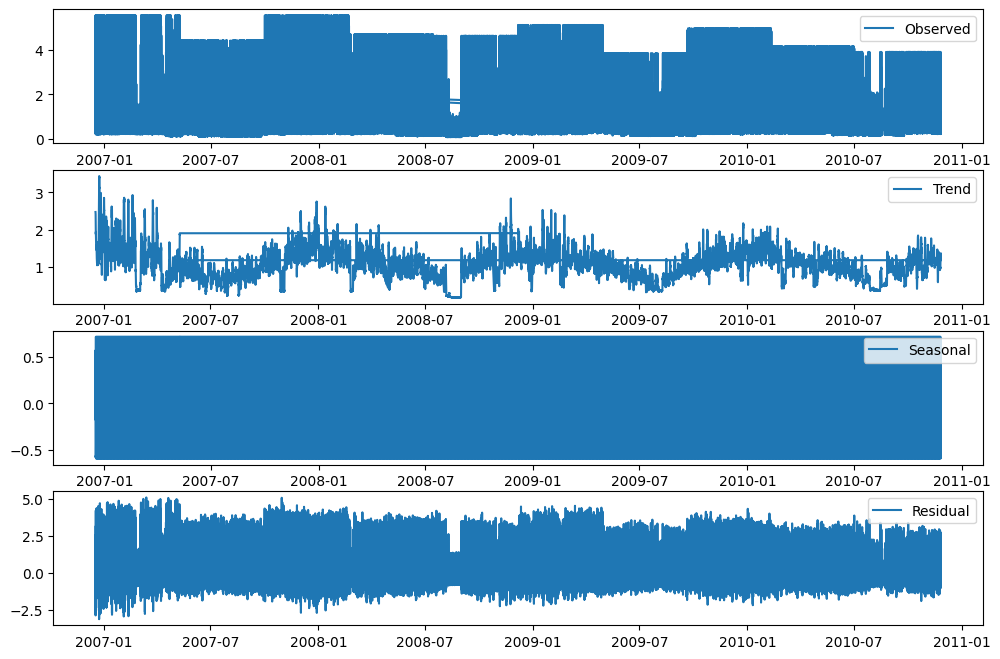

In [19]:
def check_seasonality_and_cyclical_patterns(df: pd.DataFrame):
    # Decompose the time series
    decomposition = seasonal_decompose(
        df["Global_active_power"].dropna(), model="additive", period=24 * 60
    )

    # Plot decomposition results
    plt.figure(figsize=(12, 8))
    plt.subplot(411)
    plt.plot(decomposition.observed, label="Observed")
    plt.legend(loc="upper right")
    plt.subplot(412)
    plt.plot(decomposition.trend, label="Trend")
    plt.legend(loc="upper right")
    plt.subplot(413)
    plt.plot(decomposition.seasonal, label="Seasonal")
    plt.legend(loc="upper right")
    plt.subplot(414)
    plt.plot(decomposition.resid, label="Residual")
    plt.legend(loc="upper right")
    plt.show()


check_seasonality_and_cyclical_patterns(full_df)

## 2.3 Analyze Distribution of Power Consumption

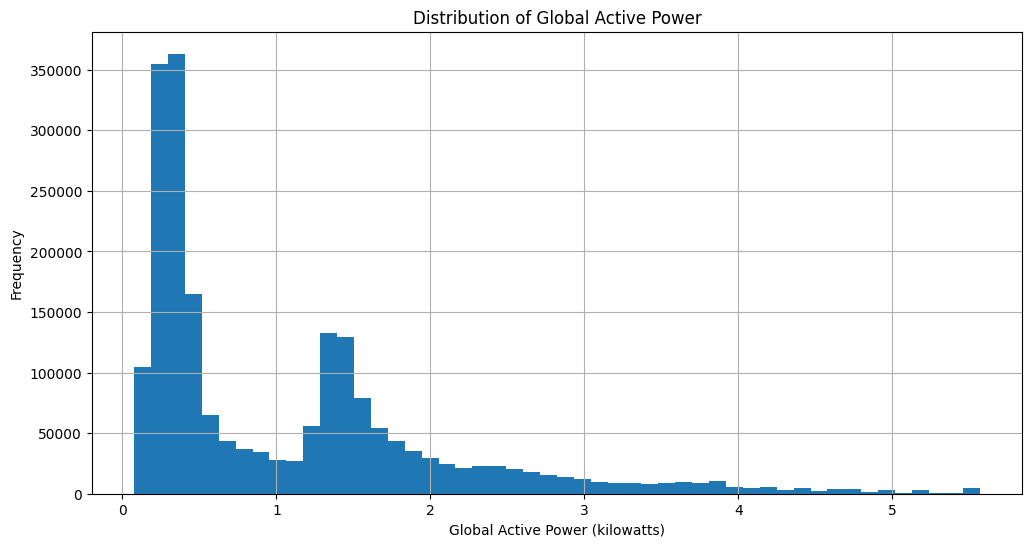

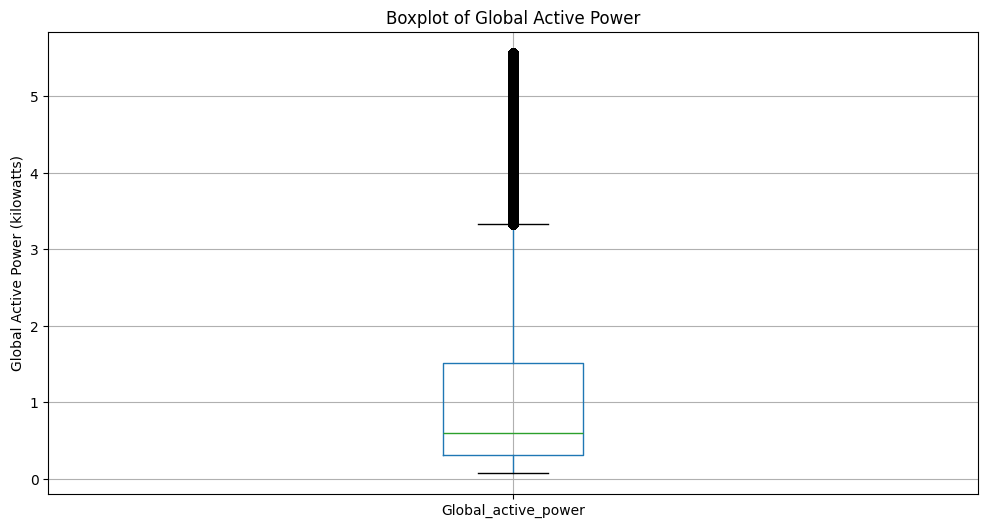

In [20]:
def analyze_distribution_of_power_consumption(df: pd.DataFrame):
    # Plot histogram
    plt.figure(figsize=(12, 6))
    df["Global_active_power"].hist(bins=50)
    plt.xlabel("Global Active Power (kilowatts)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Global Active Power")
    plt.show()

    # Plot boxplot
    plt.figure(figsize=(12, 6))
    df.boxplot(column="Global_active_power")
    plt.ylabel("Global Active Power (kilowatts)")
    plt.title("Boxplot of Global Active Power")
    plt.show()

analyze_distribution_of_power_consumption(full_df)

# 3. Implement a linear regression model to predict power consumption for the last three time periods

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from src.task_2.models.linear_regression import split_data_append_lagged_features, run_linear_regression
from src.task_2.evaluation.model_evaluation import run_model_evaluation

In [22]:
X_train, X_test, y_train, y_test = split_data_append_lagged_features(full_df)
linear_reg = run_linear_regression(X_train, y_train, X_test, y_test)

# Make predictions on the testing data
y_pred_lr = linear_reg.predict(X_test)

# Evaluate the model
lr_results = run_model_evaluation(y_test, y_pred_lr)

Training set size: (1660204, 3)
Testing set size: (415052, 3)


# 4. Evaluate the linear regression model using appropriate metrics

In [23]:
print(json.dumps(lr_results, indent=1))

{
 "Mean Absolute Error (MAE)": 0.09091245342503254,
 "Mean Squared Error (MSE)": 0.061170089665457825,
 "Root Mean Squared Error (RMSE)": 0.2473258774682864,
 "R-squared (R\u00b2) value": 0.9405323432612778
}


# 5. Implement a Recurrent Neural Network (RNN) for power consumption prediction

In [24]:
from src.task_2.models.rnn import run_rnn_model_e2e

In [25]:
run_rnn_model_e2e(full_df)

c:\Afeka\Afeka_DL_course_labs\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 4)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29 (116.00 B)

 Trainable params: 29 (116.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
6485/6485 ━━━━━━━━━━━━━━━━━━━━ 76s 11ms/step - loss: 0.2556
Epoch 2/2
6485/6485 ━━━━━━━━━━━━━━━━━━━━ 68s 10ms/step - loss: 0.0625
12970/12970 ━━━━━━━━━━━━━━━━━━━━ 51s 4ms/step - loss: 0.0593
Test loss: 0.058462414890527725
12970/12970 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step
{
 "Mean Absolute Error (MAE)": 0.08446036523314174,
 "Mean Squared Error (MSE)": 0.05846270968715681,
 "Root Mean Squared Error (RMSE)": 0.24179063192596362,
 "R-squared (R\u00b2) value": 0.9389537873903538
}


# 6. Implement Long Short-Term Memory (LSTM) for power consumption prediction

In [ ]:
from models.long_short_term_memory import run_lstm_model_e2e

In [ ]:
run_lstm_model_e2e(full_df)

# 7. Implement an LSTM model with an Attention layer for power consumption prediction

In [ ]:
from models.lstm_with_attention import run_lstm_with_attention_e2e

In [ ]:
run_lstm_with_attention_e2e(full_df)

# 8. Data augmentation experiment

In [ ]:
from task_2.data_modification.augmentation import add_noise, scale_data, shift_data, window_slicing

In [ ]:
X_combined = np.concatenate([X, add_noise(X), scale_data(X), shift_data(X), window_slicing(X)], axis=0)
y_combined = np.concatenate([y, y, y, y, y], axis=0)

In [ ]:
X_train_augment, X_test_augment, y_train_augment, y_test_augment = rnn_split(X_combined, y_combined)

# 9. Data reduction experiment

In [ ]:
from task_2.data_modification.augmentation import reduce_data_randomly

In [ ]:
# Apply reduction
X_reduced, y_reduced = reduce_data_randomly(X, y, reduction_factor=0.1)

# 10. Data resolution experiment

In [ ]:
from data_modification.resolution import resample_data_from_1min_to_2min

In [ ]:
resampled_df = resample_data_from_1min_to_2min(full_df)

# 11. Conclusion and insights